In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))
from hmpai.visualization import plot_predictions_on_epoch, predict_with_auc, show_lmer, set_seaborn_style, plot_tertile_split
import pandas as pd
from hmpai.behaviour.sat2 import read_behavioural_info, SAT2_SPLITS
from hmpai.pytorch.mamba import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

#### Create split of Low | Med | High for both conditions and save participant + epoch + split information

In [2]:
set_global_seed(42)
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_45ms.nc"]
# train_percentage=100 makes test and val 100 as well
# splits = split_participants(data_paths, train_percentage=60)
splits = SAT2_SPLITS
labels = SAT_CLASSES_ACCURACY
whole_epoch = True
info_to_keep = ["rt", "participant", "epochs", "condition", "response", "side"]
subset_cond = None  # 'speed'|'accuracy'|None
skip_samples = 62 #62
cut_samples = 63 #63
add_pe = True

In [3]:
norm_fn = norm_mad_zscore
# Shortcut so they dont have to be recalculated each time

train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
testval_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1] + splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_pe=add_pe,
)

In [4]:
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
test_loader = DataLoader(
    testval_data, batch_size=128, shuffle=False, num_workers=8, pin_memory=True
)

In [5]:
chk_path = Path("../../models/final_45ms.pt")
checkpoint = load_model(chk_path)
config = {
    "n_channels": 64,
    "n_classes": len(labels),
    "n_mamba_layers": 5,
    "use_pointconv_fe": True,
    "spatial_feature_dim": 128,
    "use_conv": True,
    "conv_kernel_sizes": [3, 9, 27],
    "conv_in_channels": [128, 128, 128],
    "conv_out_channels": [256, 256, 256],
    "conv_concat": True,
    "use_pos_enc": True,
}

model = build_mamba(config)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

In [6]:
data = predict_with_auc(model, test_loader, info_to_keep, SAT_CLASSES_ACCURACY)

In [7]:
data["confirmation_auc"] = data["confirmation_auc"] / data["rt"]
data["tertile"] = data.groupby(["participant", "condition"])["confirmation_auc"].transform(
    lambda x: pd.qcut(x, q=3, labels=[0, 1, 2])
)
data["correct"] = data["response"] == data["side"]

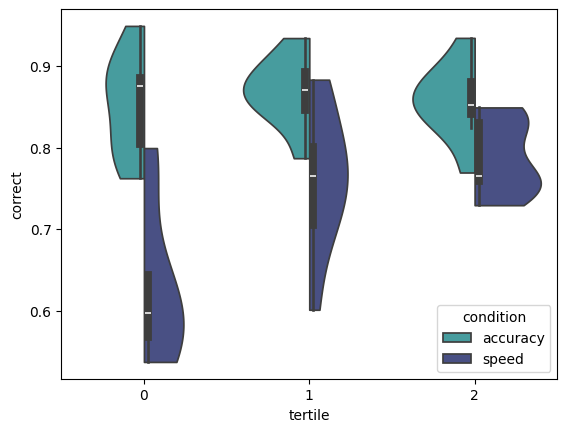

In [8]:
# Plot to check if result is the same
participant_ratios = (
    data.groupby(["participant", "condition", "tertile"], observed=True)
    .correct.mean()
    .reset_index()
)
sns.violinplot(
    x="tertile",
    y="correct",
    data=participant_ratios,
    hue="condition",
    split=True,
    palette="mako_r",
    cut=0,
)
plt.show()

In [9]:
# Load data
ds = xr.load_dataset(data_paths[0])

In [10]:
# Add tertile info to data
data_pivot = data.pivot(index='participant', columns='epochs', values='tertile')
da_tertile = xr.DataArray(data_pivot.values, dims=['participant', 'epochs'], coords={'participant': data_pivot.index, 'epochs': data_pivot.columns})
ds = ds.assign_coords(tertile=da_tertile)
# Drop participants that were not part of test/val sets, so where tertile is not assigned
ds = ds.where(ds['tertile'].notnull(), drop=True)

In [11]:
ds

<xarray.Dataset> Size: 12GB
Dimensions:        (participant: 9, epochs: 2448, channels: 64, samples: 1049,
                    labels: 5)
Coordinates: (12/16)
  * epochs         (epochs) int64 20kB 0 1 2 3 4 5 ... 2443 2444 2445 2446 2447
  * channels       (channels) <U3 768B 'Fp1' 'AF7' 'AF3' ... 'PO8' 'PO4' 'O2'
  * samples        (samples) int64 8kB 0 1 2 3 4 5 ... 1044 1045 1046 1047 1048
    event_name     (participant, epochs) <U26 2MB 'stim/low/accuracy/right/3'...
    rt             (participant, epochs) float64 176kB 0.732 0.598 ... 0.228
    stimulus       (participant, epochs) <U21 2MB 'low/accuracy/right/3' ... ...
    ...             ...
    side           (participant, epochs) <U5 441kB 'right' 'right' ... 'left'
    contrast       (participant, epochs) <U1 88kB '3' '1' '1' '1' ... '' '2' '1'
  * participant    (participant) <U3 108B 'S10' 'S11' 'S15' ... 'S5' 'S7' 'S8'
    givenResp      (participant, epochs) <U5 441kB 'right' 'right' ... 'left'
    trialType      (participant, epochs) <U3 264kB 'SA' 'SA' 'SA' ... 'SA' 'SA'
    tertile        (participant, epochs) object 176kB 2 2 1 0 1 ... nan nan 0 0
Dimensions without coordinates: labels
Data variables:
    data           (participant, epochs, channels, samples) float64 12GB 1.27...
    probabilities  (participant, epochs, labels, samples) float32 462MB 0.0 ....
Attributes:
    sfreq:           250.0
    offset:          0
    offset_before:   62
    lowpass:         50.0
    highpass:        1.0
    lower_limit_RT:  0.2
    upper_limit_RT:  3.754
    extra_offset:    62

In [12]:
# Save data
ds.to_netcdf(DATA_PATH / 'sat2/stage_data_proba_250hz_45ms_tertile.nc')